In [1]:
import torch
from tqdm.auto import tqdm
from PIL import Image
import numpy as np

from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel
from diffusers import LMSDiscreteScheduler


def latents_to_pil(latents, vae):
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

class StableDiffusion:
    def __init__(
            self,
            sd_model="CompVis/stable-diffusion-v1-4",
            encoder_model="openai/clip-vit-large-patch14",
            max_embeddings_length=77,
        ):
        self.tokenizer = CLIPTokenizer.from_pretrained(encoder_model, torch_dtype=torch.float16)
        self.text_encoder = CLIPTextModel.from_pretrained(encoder_model, torch_dtype=torch.float16).to("cuda")
        self.vae = AutoencoderKL.from_pretrained(sd_model, subfolder="vae", torch_dtype=torch.float16).to("cuda")
        self.unet = UNet2DConditionModel.from_pretrained(sd_model, subfolder="unet", torch_dtype=torch.float16).to("cuda")

        self.max_embeddings_length = max_embeddings_length
        self.unconditional_embeddings =  self.encode_text([""])

    def encode_text(self, prompts):
        inp = self.tokenizer(
            prompts,
            padding="max_length",
            max_length=self.max_embeddings_length,
            truncation=True,
            return_tensors="pt"
        ) 
        return self.text_encoder(inp.input_ids.to("cuda"))[0].half()

    def generate(self, embeddings,  g=7.5, seed=100, steps=70, dim=512):
        bs = embeddings.shape[0]
        embeddings = embeddings.to("cuda").half()

        scheduler = LMSDiscreteScheduler(
            beta_start=0.00085,
            beta_end=0.012,
            beta_schedule="scaled_linear",
            num_train_timesteps=1000
        )
        scheduler.set_timesteps(steps)

        latents = torch.randn((bs, self.unet.config.in_channels, dim//8, dim//8))
        latents = latents.to("cuda").half() * scheduler.init_noise_sigma

        emb = torch.cat([torch.cat([self.unconditional_embeddings] * bs), embeddings])
        
        history = []
        for i,ts in enumerate(tqdm(scheduler.timesteps)):
            inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)
            with torch.no_grad():
                u,t = self.unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)
                
            pred = u + g*(t-u)
            latents = scheduler.step(pred, ts, latents).prev_sample
            
            partial_image = latents_to_pil(latents, self.vae)
            history.append(partial_image)
        
        return history 


In [2]:
sd = StableDiffusion()
text_embeddings = sd.encode_text([
    "Cute picture of a dog",
])

history = sd.generate(text_embeddings, steps=80)

  0%|          | 0/80 [00:00<?, ?it/s]

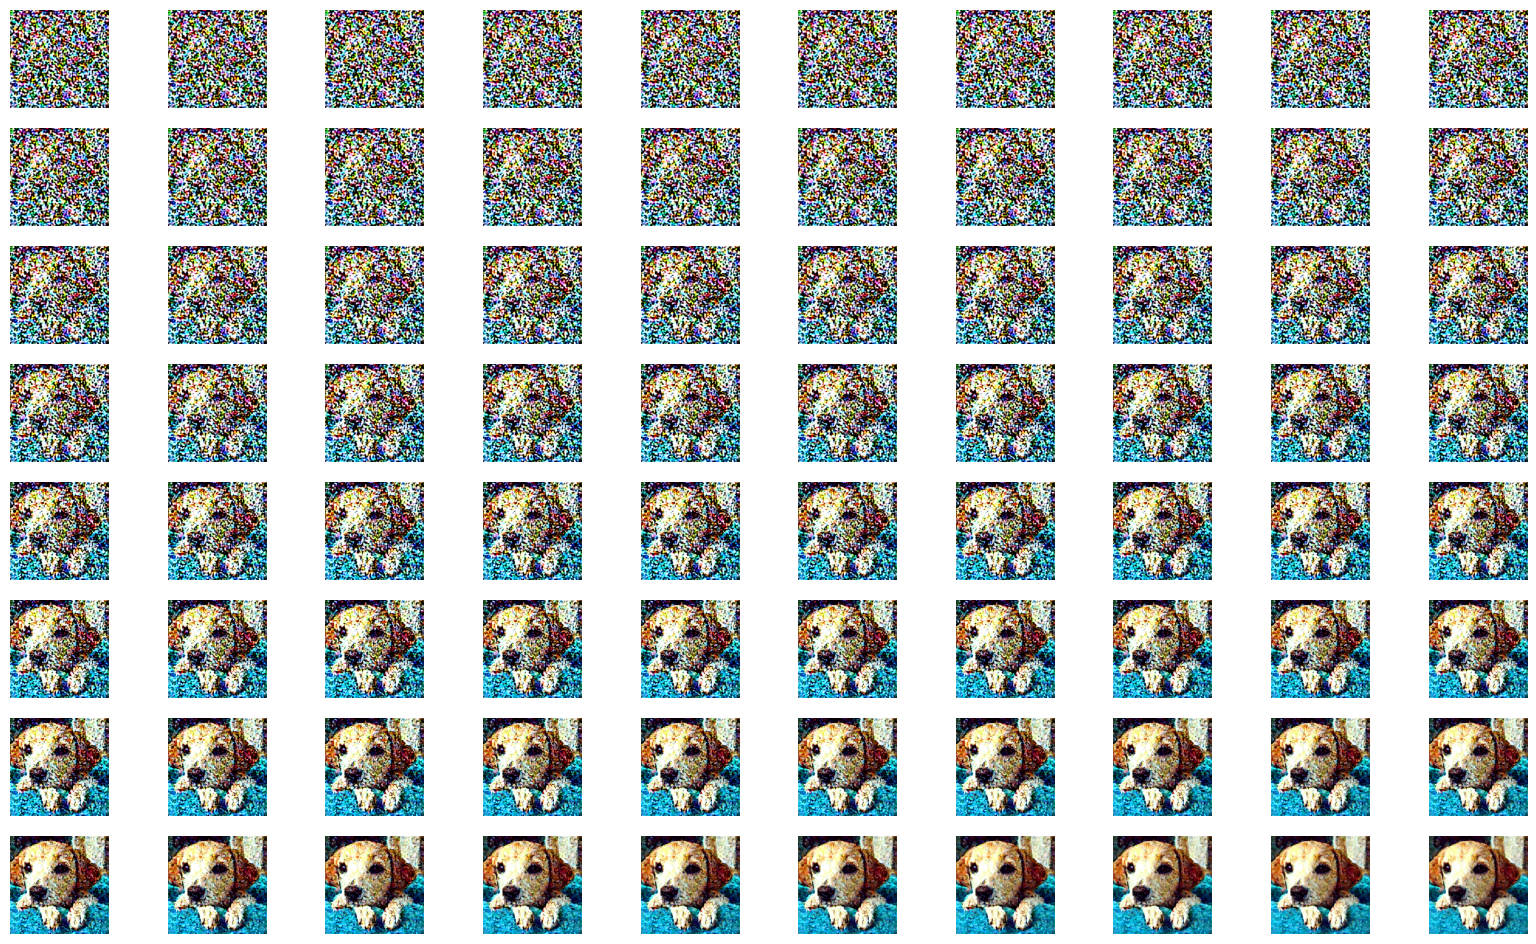

In [3]:
from matplotlib import pyplot as plt

plt, axes = plt.subplots(8, 10, figsize=(20, 12))
for i in range(0, 8):
    for j in range(0, 10):
        frame = history[i*8 + j][0]
        axes[i, j].imshow(frame)
        axes[i, j].axis("off")


In [4]:
import clip
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device)

100%|██████████| 80/80 [00:00<00:00, 102.12it/s]


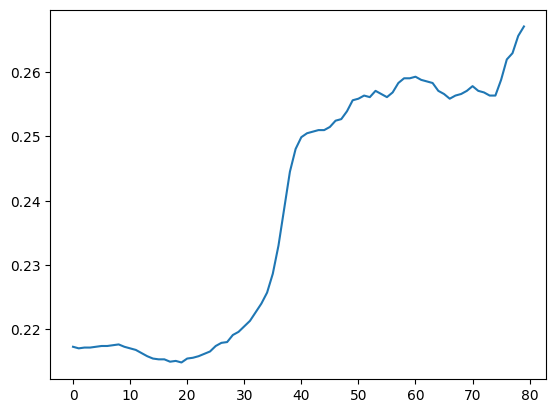

In [34]:
from tqdm import tqdm
from matplotlib import pyplot as plt

text_features = clip_model.encode_text(clip.tokenize(["Cute picture of a dog"]).to("cuda"))

toplot = []
for frame in tqdm(history):
    processed_frame = preprocess(frame[0]).to("cuda").unsqueeze(0)
    image_features = clip_model.encode_image(processed_frame)
    dist = torch.nn.functional.cosine_similarity(text_features, image_features)
    
    toplot.append(dist.item())
    
plt.plot(toplot)